# Исследовательская часть

Приведем код классификатора без улучшений

In [1]:
%matplotlib inline
import re
from collections import defaultdict
import sys
from math import log
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [2]:
def preprocessing(text):
    text = text.lower()
    remove_tags = re.compile('<.*?>')
    text = re.sub(remove_tags, '', text)
    text = ''.join(sym if (sym.isalnum() or sym in (" ", )) else f" {sym} " for sym in text)
    return text

In [3]:
def tokenize_dataset(dataset):
    """
        arg: list of texts
        return: list of tokenized texts
    """
    tokenizer = re.compile("-?\d*[.,]?\d+|[\w]+|\S", re.MULTILINE | re.IGNORECASE)
    return list(map(lambda doc: tokenizer.findall(doc), dataset))

In [4]:
def train(dataset, labels, **kwargs):
    word_to_ind = {}
    free_ind = 0

    pos_words = defaultdict(int)
    word_in_pos_text = defaultdict(int)
    neg_words = defaultdict(int)
    word_in_neg_text = defaultdict(int)
    cnt_pos = 0
    cnt_neg = 0
    N_words = -1
    prob_w_cls = []
    prob_cls = []
    bigrams = True
    #--------------------------------------
    train_pos = [dataset[i] for i, lab in enumerate(labels) if lab == 'pos']
    train_pos = list(map(preprocessing, train_pos))
    train_pos = tokenize_dataset(train_pos)

    train_neg = [dataset[i] for i, lab in enumerate(labels) if lab == 'neg']
    train_neg = list(map(preprocessing, train_neg))
    train_neg = tokenize_dataset(train_neg)

    for text in train_pos:
        been = set()
        for word in text:
            pos_words[word] += 1
            cnt_pos += 1
            if word not in word_to_ind:
                word_to_ind[word] = free_ind
                free_ind += 1
            if word not in been:
                ind = word_to_ind[word]
                word_in_pos_text[ind] += 1
                been.add(word)

    if bigrams:
        for text in train_pos:
            been = set()
            bigrams = [b for b in zip(text[:-1], text[1:])]
            for word in bigrams:
                pos_words[word] += 1
                cnt_pos += 1
                if word not in word_to_ind:
                    word_to_ind[word] = free_ind
                    free_ind += 1
                if word not in been:
                    ind = word_to_ind[word]
                    word_in_pos_text[ind] += 1
                    been.add(word)

    for text in train_neg:
        been = set()
        for word in text:
            neg_words[word] += 1
            cnt_neg += 1
            if word not in word_to_ind:
                word_to_ind[word] = free_ind
                free_ind += 1
            if word not in been:
                ind = word_to_ind[word]
                word_in_neg_text[ind] += 1
                been.add(word)    

    if bigrams:
        for text in train_neg:
            been = set()
            bigrams = [b for b in zip(text[:-1], text[1:])]
            for word in bigrams:
                neg_words[word] += 1
                cnt_neg += 1
                if word not in word_to_ind:
                    word_to_ind[word] = free_ind
                    free_ind += 1
                if word not in been:
                    ind = word_to_ind[word]
                    word_in_neg_text[ind] += 1
                    been.add(word)

    N_words = len(word_to_ind)

    def cnt_prob_word_cls(ind, cls):
        if cls == 'neg':
            cnt = word_in_neg_text[ind] if ind != -1 else 0
            return (1 + cnt) / (cnt_neg + len(word_to_ind))
        else:
            cnt = word_in_pos_text[ind] if ind != -1 else 0
            return (1 + cnt) / (cnt_pos + len(word_to_ind))

    def cnt_prob_cls(cls):
    # 0 - neg, 1 - pos
        if cls == 0:
            return len(train_neg) / (len(train_neg) + len(train_pos))
        else:
            return len(train_pos) / (len(train_neg) + len(train_pos))

    prob_w_cls = [[cnt_prob_word_cls(i, cls) for i in range(N_words)] + [cnt_prob_word_cls(-1, cls)] for cls in ('neg', 'pos')]
    prob_cls = [cnt_prob_cls(cls) for cls in ('neg', 'pos')]

    return word_to_ind, prob_w_cls, prob_cls, bigrams

In [5]:
def vectorize(tokenized_texts, word_to_ind, mode, bigrams=True):
    res = [defaultdict(int) for _ in range(len(tokenized_texts))]
    for ind, text in enumerate(tokenized_texts):
        for token in text:
            if token in word_to_ind:
                res[ind][word_to_ind[token]] += 1
            else:
                res[ind][-1] += 1
    if bigrams:
        for ind, text in enumerate(tokenized_texts):
            bigrams = [b for b in zip(text[:-1], text[1:])]
            for token in bigrams:
                if token in word_to_ind:
                    res[ind][word_to_ind[token]] += 1
                else:
                    res[ind][-1] += 1
    if mode == 'bern':
        for text in res:
            for k, v in text.items():
                if v > 0:
                    text[k] = 1
    return res

In [6]:
def classify_mult(vectorized_text, prob_w_cls, prob_cls):
    # 0 - neg, 1 - pos
    classes = (0, 1)
    res = []
    for cls in classes:
        cur_res = 0
        for word in vectorized_text.keys():
            try:
                cur_res += log(prob_w_cls[cls][word]) * vectorized_text[word]
            except Exception:
                print(cls, word, len(vectorized_text), len(prob_w_cls[0]), len(prob_w_cls[1]))
        cur_res += log(prob_cls[cls])
        res.append(cur_res)
    if res[0] > res[1]:
        label = 0
    else:
        label = 1
    return label

In [7]:
def classify(dataset, params):
    #preprocessing
    word_to_ind, prob_w_cls, prob_cls, bigr = params
    dataset = list(map(preprocessing, dataset))
    dataset = tokenize_dataset(dataset)
    dataset = vectorize(dataset, word_to_ind, mode='mult', bigrams=bigr)
    probs = []
    size = len(dataset)
    for i, text in enumerate(dataset):
        probs.append(classify_mult(text, prob_w_cls, prob_cls))
    res = ['pos' if pr else 'neg' for pr in probs]
    return res

In [8]:
def score(my_labels, corr_labels):
    corr = 0
    for pair in zip(my_labels, corr_labels):
        corr += int(pair[0] == pair[1])
    return corr / len(my_labels)

In [9]:
def test_model(train_params):
    train_texts_path = "./filimdb_evaluation/FILIMDB/train.texts"
    train_labels_path = "./filimdb_evaluation/FILIMDB/train.labels"

    dev_texts_path = "./filimdb_evaluation/FILIMDB/dev.texts"
    dev_labels_path = "./filimdb_evaluation/FILIMDB/dev.labels"

    with open(train_texts_path, 'r', encoding='utf-8') as inp:
        train_data = list(map(str.strip, inp.readlines()))
    with open(train_labels_path, 'r', encoding='utf-8') as inp:
        train_labels = list(map(str.strip, inp.readlines()))

    with open(dev_texts_path, 'r', encoding='utf-8') as inp:
        dev_data = list(map(str.strip, inp.readlines()))
    with open(dev_labels_path, 'r', encoding='utf-8') as inp:
        dev_labels = list(map(str.strip, inp.readlines()))

    train_info = train(train_data, train_labels, **train_params)
    print("TRAINING DONE")
    train_acc = score(classify(train_data, train_info), train_labels)
    dev_acc = score(classify(dev_data, train_info), dev_labels)
    print("CLASSIFY DONE")
    return pd.DataFrame(index=[1],data={'train_acc':train_acc, 'dev_acc':dev_acc}), (train_acc, dev_acc), len(train_info[0])

Изначальные значения мультиномиальной модели с биграммами.

In [10]:
test_model({})[0]

TRAINING DONE
CLASSIFY DONE


,train_acc,dev_acc
1,0.986267,0.8669


### 1. 
**Попробуйте удалить из словаря слова, которые встретились < tf_min_cnt раз.**

In [11]:
def train(dataset, labels, tf_min_cnt=2, bigrams=True):
    word_to_ind = {}
    free_ind = 0

    pos_words = defaultdict(int)
    word_in_pos_text = defaultdict(int)
    neg_words = defaultdict(int)
    word_in_neg_text = defaultdict(int)
    cnt_pos = 0
    cnt_neg = 0
    N_words = -1
    prob_w_cls = []
    prob_cls = []
#     bigrams = True
    #--------------------------------------
    train_pos = [dataset[i] for i, lab in enumerate(labels) if lab == 'pos']
    train_pos = list(map(preprocessing, train_pos))
    train_pos = tokenize_dataset(train_pos)

    train_neg = [dataset[i] for i, lab in enumerate(labels) if lab == 'neg']
    train_neg = list(map(preprocessing, train_neg))
    train_neg = tokenize_dataset(train_neg)

    for text in train_pos:
        been = set()
        for word in text:
            pos_words[word] += 1
            cnt_pos += 1
            if word not in word_to_ind:
                word_to_ind[word] = free_ind
                free_ind += 1
            if word not in been:
                ind = word_to_ind[word]
                word_in_pos_text[ind] += 1
                been.add(word)

    if bigrams:
        for text in train_pos:
            been = set()
            bigrams = [b for b in zip(text[:-1], text[1:])]
            for word in bigrams:
                pos_words[word] += 1
                cnt_pos += 1
                if word not in word_to_ind:
                    word_to_ind[word] = free_ind
                    free_ind += 1
                if word not in been:
                    ind = word_to_ind[word]
                    word_in_pos_text[ind] += 1
                    been.add(word)

    for text in train_neg:
        been = set()
        for word in text:
            neg_words[word] += 1
            cnt_neg += 1
            if word not in word_to_ind:
                word_to_ind[word] = free_ind
                free_ind += 1
            if word not in been:
                ind = word_to_ind[word]
                word_in_neg_text[ind] += 1
                been.add(word)    

    if bigrams:
        for text in train_neg:
            been = set()
            bigrams = [b for b in zip(text[:-1], text[1:])]
            for word in bigrams:
                neg_words[word] += 1
                cnt_neg += 1
                if word not in word_to_ind:
                    word_to_ind[word] = free_ind
                    free_ind += 1
                if word not in been:
                    ind = word_to_ind[word]
                    word_in_neg_text[ind] += 1
                    been.add(word)

    # Deleting words with term_freq < min_cnt.
    for w, ind in list(word_to_ind.items()):
        w_pos = pos_words[w]
        w_neg = neg_words[w]
        if w_pos + w_neg < tf_min_cnt:
            cnt_pos -= w_pos
            cnt_neg -= w_neg
            pos_words.pop(w, -1)
            neg_words.pop(w, -1)
            word_in_pos_text.pop(ind, -1)
            word_in_neg_text.pop(ind, -1)
            word_to_ind.pop(w, -1)
    
    new_word_to_ind = {}
    new_word_in_neg_text = {}
    new_word_in_pos_text = {}
    for ind, (w, old_ind) in enumerate(word_to_ind.items()):
        try:
            new_word_to_ind[w] = ind
            new_word_in_neg_text[ind] = word_in_neg_text[old_ind]
            new_word_in_pos_text[ind] = word_in_pos_text[old_ind]
        except Exception:
            print(ind, w, old_ind)
    
    word_to_ind = new_word_to_ind
    word_in_pos_text = new_word_in_pos_text
    word_in_neg_text = new_word_in_neg_text
    
    N_words = len(word_to_ind)

    def cnt_prob_word_cls(ind, cls):
        if cls == 'neg':
            cnt = word_in_neg_text[ind] if ind != -1 else 0
            return (1 + cnt) / (cnt_neg + len(word_to_ind))
        else:
            cnt = word_in_pos_text[ind] if ind != -1 else 0
            return (1 + cnt) / (cnt_pos + len(word_to_ind))

    def cnt_prob_cls(cls):
    # 0 - neg, 1 - pos
        if cls == 0:
            return len(train_neg) / (len(train_neg) + len(train_pos))
        else:
            return len(train_pos) / (len(train_neg) + len(train_pos))

    prob_w_cls = [[cnt_prob_word_cls(i, cls) for i in range(N_words)] + [cnt_prob_word_cls(-1, cls)] for cls in ('neg', 'pos')]
    prob_cls = [cnt_prob_cls(cls) for cls in ('neg', 'pos')]

    return word_to_ind, prob_w_cls, prob_cls, bigrams

In [12]:
def graph_accs(train_accs, dev_accs, dict_size):
    fig, ax = plt.subplots(1, 2, figsize=(12,5))
    ax[0].plot(dict_size, train_accs)
    ax[0].set_ylabel("train_acc")
    ax[0].set_xlabel("dict_size")
    ax[1].plot(dict_size, dev_accs)
    ax[1].set_ylabel("dev_acc")
    ax[1].set_xlabel("dict_size")
    plt.show()

**Результаты для униграмной модели**

TRAINING DONE
CLASSIFY DONE
TRAINING DONE
CLASSIFY DONE
TRAINING DONE
CLASSIFY DONE
TRAINING DONE
CLASSIFY DONE
TRAINING DONE
CLASSIFY DONE
TRAINING DONE
CLASSIFY DONE
TRAINING DONE
CLASSIFY DONE
TRAINING DONE
CLASSIFY DONE
TRAINING DONE
CLASSIFY DONE


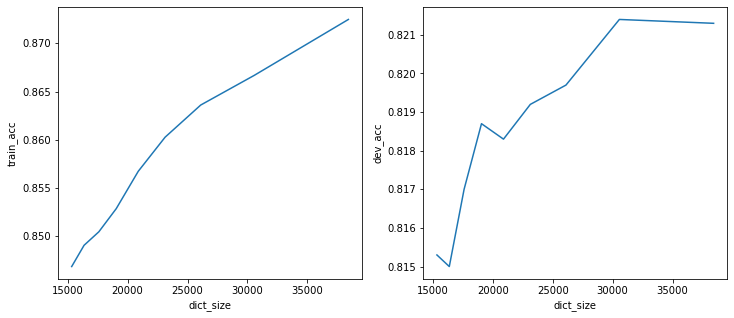

In [16]:
test_accs = []
dev_accs = []
dict_size = []
for tf in range(2, 11):
    res = test_model({'tf_min_cnt' : tf, 'bigrams': False})
    test_accs.append(res[1][0])
    dev_accs.append(res[1][1])
    dict_size.append(res[2])
graph_accs(test_accs, dev_accs, dict_size)

**Результат для биграмной модели.**

TRAINING DONE
CLASSIFY DONE
TRAINING DONE
CLASSIFY DONE
TRAINING DONE
CLASSIFY DONE
TRAINING DONE
CLASSIFY DONE
TRAINING DONE
CLASSIFY DONE
TRAINING DONE
CLASSIFY DONE
TRAINING DONE
CLASSIFY DONE
TRAINING DONE
CLASSIFY DONE
TRAINING DONE
CLASSIFY DONE


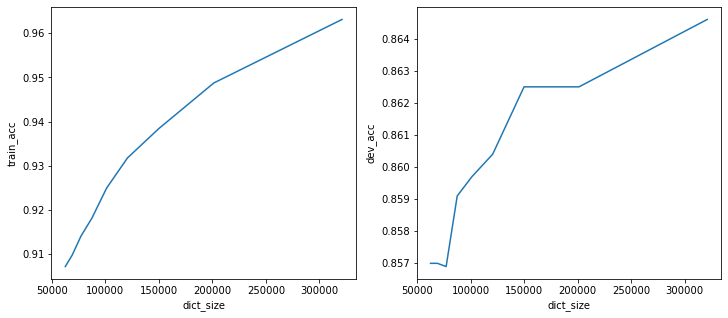

In [17]:
test_accs = []
dev_accs = []
dict_size = []
for tf in range(2, 11):
    res = test_model({'tf_min_cnt' : tf, 'bigrams': True})
    test_accs.append(res[1][0])
    dev_accs.append(res[1][1])
    dict_size.append(res[2])
graph_accs(test_accs, dev_accs, dict_size)

#### Теперь проверим отсечение по document_frec

In [18]:
def train(dataset, labels, df_min_cnt=3, bigrams=True):
    word_to_ind = {}
    free_ind = 0

    pos_words = defaultdict(int)
    word_in_pos_text = defaultdict(int)
    neg_words = defaultdict(int)
    word_in_neg_text = defaultdict(int)
    cnt_pos = 0
    cnt_neg = 0
    N_words = -1
    prob_w_cls = []
    prob_cls = []
#     bigrams = False
    #--------------------------------------
    train_pos = [dataset[i] for i, lab in enumerate(labels) if lab == 'pos']
    train_pos = list(map(preprocessing, train_pos))
    train_pos = tokenize_dataset(train_pos)

    train_neg = [dataset[i] for i, lab in enumerate(labels) if lab == 'neg']
    train_neg = list(map(preprocessing, train_neg))
    train_neg = tokenize_dataset(train_neg)

    for text in train_pos:
        been = set()
        for word in text:
            pos_words[word] += 1
            cnt_pos += 1
            if word not in word_to_ind:
                word_to_ind[word] = free_ind
                free_ind += 1
            if word not in been:
                ind = word_to_ind[word]
                word_in_pos_text[ind] += 1
                been.add(word)

    if bigrams:
        for text in train_pos:
            been = set()
            bigrams = [b for b in zip(text[:-1], text[1:])]
            for word in bigrams:
                pos_words[word] += 1
                cnt_pos += 1
                if word not in word_to_ind:
                    word_to_ind[word] = free_ind
                    free_ind += 1
                if word not in been:
                    ind = word_to_ind[word]
                    word_in_pos_text[ind] += 1
                    been.add(word)

    for text in train_neg:
        been = set()
        for word in text:
            neg_words[word] += 1
            cnt_neg += 1
            if word not in word_to_ind:
                word_to_ind[word] = free_ind
                free_ind += 1
            if word not in been:
                ind = word_to_ind[word]
                word_in_neg_text[ind] += 1
                been.add(word)    

    if bigrams:
        for text in train_neg:
            been = set()
            bigrams = [b for b in zip(text[:-1], text[1:])]
            for word in bigrams:
                neg_words[word] += 1
                cnt_neg += 1
                if word not in word_to_ind:
                    word_to_ind[word] = free_ind
                    free_ind += 1
                if word not in been:
                    ind = word_to_ind[word]
                    word_in_neg_text[ind] += 1
                    been.add(word)

    # Deleting words with doc_freq < min_cnt.
    for w, ind in list(word_to_ind.items()):
        w_pos_text = word_in_pos_text[ind]
        w_neg_text = word_in_neg_text[ind]
        if w_pos_text + w_neg_text < df_min_cnt:
            cnt_pos -= pos_words[w]
            cnt_neg -= neg_words[w]
            pos_words.pop(w, -1)
            neg_words.pop(w, -1)
            word_in_pos_text.pop(ind, -1)
            word_in_neg_text.pop(ind, -1)
            word_to_ind.pop(w, -1)
    
    new_word_to_ind = {}
    new_word_in_neg_text = {}
    new_word_in_pos_text = {}
    for ind, (w, old_ind) in enumerate(word_to_ind.items()):
        try:
            new_word_to_ind[w] = ind
            new_word_in_neg_text[ind] = word_in_neg_text[old_ind]
            new_word_in_pos_text[ind] = word_in_pos_text[old_ind]
        except Exception:
            print(ind, w, old_ind)
    
    word_to_ind = new_word_to_ind
    word_in_pos_text = new_word_in_pos_text
    word_in_neg_text = new_word_in_neg_text
    
    N_words = len(word_to_ind)

    def cnt_prob_word_cls(ind, cls):
        if cls == 'neg':
            cnt = word_in_neg_text[ind] if ind != -1 else 0
            return (1 + cnt) / (cnt_neg + len(word_to_ind))
        else:
            cnt = word_in_pos_text[ind] if ind != -1 else 0
            return (1 + cnt) / (cnt_pos + len(word_to_ind))

    def cnt_prob_cls(cls):
    # 0 - neg, 1 - pos
        if cls == 0:
            return len(train_neg) / (len(train_neg) + len(train_pos))
        else:
            return len(train_pos) / (len(train_neg) + len(train_pos))

    prob_w_cls = [[cnt_prob_word_cls(i, cls) for i in range(N_words)] + [cnt_prob_word_cls(-1, cls)] for cls in ('neg', 'pos')]
    prob_cls = [cnt_prob_cls(cls) for cls in ('neg', 'pos')]

    return word_to_ind, prob_w_cls, prob_cls, bigrams

**Точность для униграмной модели**

TRAINING DONE
CLASSIFY DONE
TRAINING DONE
CLASSIFY DONE
TRAINING DONE
CLASSIFY DONE


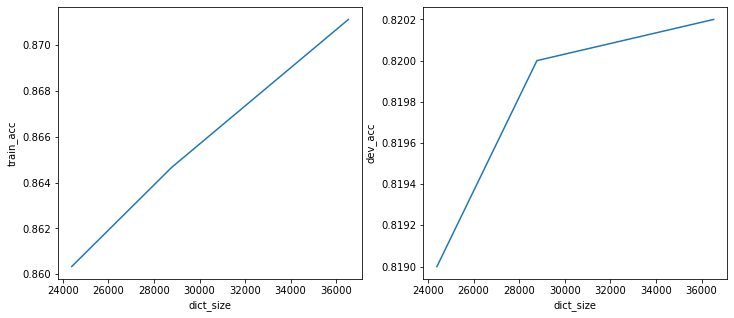

In [20]:
test_accs = []
dev_accs = []
dict_size = []
for df in range(2, 5):
    res = test_model({'df_min_cnt' : df, 'bigrams': False})
    test_accs.append(res[1][0])
    dev_accs.append(res[1][1])
    dict_size.append(res[2])
graph_accs(test_accs, dev_accs, dict_size)

**Точность для биграмной модели**

TRAINING DONE
CLASSIFY DONE
TRAINING DONE
CLASSIFY DONE
TRAINING DONE
CLASSIFY DONE


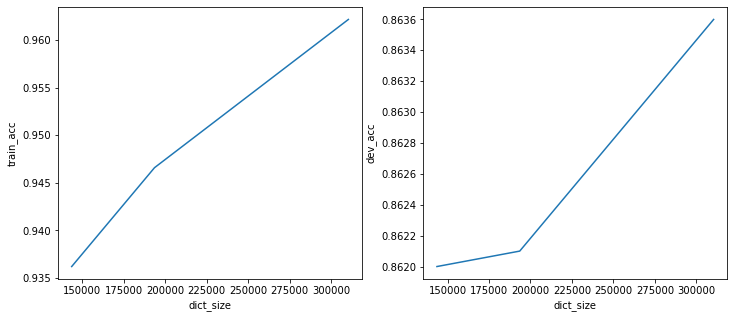

In [21]:
test_accs = []
dev_accs = []
dict_size = []
for df in range(2, 5):
    res = test_model({'df_min_cnt' : df, 'bigrams': True})
    test_accs.append(res[1][0])
    dev_accs.append(res[1][1])
    dict_size.append(res[2])
graph_accs(test_accs, dev_accs, dict_size)

На всех моделях можно наблюдать снижении точности.\
Я думаю это происходит из-за того, что тексты становятся более похожими друг на друга, ведь уникальные слова удаляются. И доля местоимений, служебных слов и других бесполезных для классификации слов становится больше.\
При одинаковых размерах словаря точность на dev датасете примерно одинакова для этих ограничений.

### b) Что будет, если не учитывать частоты слов в мультиномиальном байесе?

In [22]:
def train(dataset, labels, tf_min_cnt=3, bigrams=True):
    word_to_ind = {}
    free_ind = 0

    pos_words = defaultdict(int)
    word_in_pos_text = defaultdict(int)
    neg_words = defaultdict(int)
    word_in_neg_text = defaultdict(int)
    cnt_pos = 0
    cnt_neg = 0
    N_words = -1
    prob_w_cls = []
    prob_cls = []
#     bigrams = True
    #--------------------------------------
    train_pos = [dataset[i] for i, lab in enumerate(labels) if lab == 'pos']
    train_pos = list(map(preprocessing, train_pos))
    train_pos = tokenize_dataset(train_pos)

    train_neg = [dataset[i] for i, lab in enumerate(labels) if lab == 'neg']
    train_neg = list(map(preprocessing, train_neg))
    train_neg = tokenize_dataset(train_neg)

    for text in train_pos:
        been = set()
        for word in text:
            pos_words[word] += 1
            cnt_pos += 1
            if word not in word_to_ind:
                word_to_ind[word] = free_ind
                free_ind += 1
            if word not in been:
                ind = word_to_ind[word]
                word_in_pos_text[ind] += 1
                been.add(word)

    if bigrams:
        for text in train_pos:
            been = set()
            bigrams = [b for b in zip(text[:-1], text[1:])]
            for word in bigrams:
                pos_words[word] += 1
                cnt_pos += 1
                if word not in word_to_ind:
                    word_to_ind[word] = free_ind
                    free_ind += 1
                if word not in been:
                    ind = word_to_ind[word]
                    word_in_pos_text[ind] += 1
                    been.add(word)

    for text in train_neg:
        been = set()
        for word in text:
            neg_words[word] += 1
            cnt_neg += 1
            if word not in word_to_ind:
                word_to_ind[word] = free_ind
                free_ind += 1
            if word not in been:
                ind = word_to_ind[word]
                word_in_neg_text[ind] += 1
                been.add(word)    

    if bigrams:
        for text in train_neg:
            been = set()
            bigrams = [b for b in zip(text[:-1], text[1:])]
            for word in bigrams:
                neg_words[word] += 1
                cnt_neg += 1
                if word not in word_to_ind:
                    word_to_ind[word] = free_ind
                    free_ind += 1
                if word not in been:
                    ind = word_to_ind[word]
                    word_in_neg_text[ind] += 1
                    been.add(word)
    
    N_words = len(word_to_ind)

    def cnt_prob_word_cls(ind, cls):
        if cls == 'neg':
            cnt = word_in_neg_text[ind] if ind != -1 else 0
            return (1 + cnt) / (cnt_neg + len(word_to_ind))
        else:
            cnt = word_in_pos_text[ind] if ind != -1 else 0
            return (1 + cnt) / (cnt_pos + len(word_to_ind))

    def cnt_prob_cls(cls):
    # 0 - neg, 1 - pos
        if cls == 0:
            return len(train_neg) / (len(train_neg) + len(train_pos))
        else:
            return len(train_pos) / (len(train_neg) + len(train_pos))

    prob_w_cls = [[cnt_prob_word_cls(i, cls) for i in range(N_words)] + [cnt_prob_word_cls(-1, cls)] for cls in ('neg', 'pos')]
    prob_cls = [cnt_prob_cls(cls) for cls in ('neg', 'pos')]

    return word_to_ind, prob_w_cls, prob_cls, bigrams

In [23]:
def classify(dataset, params):
    #preprocessing
    word_to_ind, prob_w_cls, prob_cls, bigr = params
    dataset = list(map(preprocessing, dataset))
    dataset = tokenize_dataset(dataset)
    dataset = vectorize(dataset, word_to_ind, mode='bern', bigrams=bigr)
    probs = []
    size = len(dataset)
    for i, text in enumerate(dataset):
        probs.append(classify_mult(text, prob_w_cls, prob_cls))
    res = ['pos' if pr else 'neg' for pr in probs]
    return res

test_model({'bigrams':True})[0]

TRAINING DONE
CLASSIFY DONE


,train_acc,dev_acc
1,0.992467,0.8737


Прирост в точности на 0.8 на dev датасете.\
Я думаю это происходит, потому что частые служебные слова перестают так сильно вносить вклад в общую вероятность.\
При этом точность 99.2 на train датасете может говорить о некотором переобучении.

**b.2) Попробуем удалить самые часто встречающиеся слова в выборке.**

Построим гистограмму частотности слов в документах.

956246


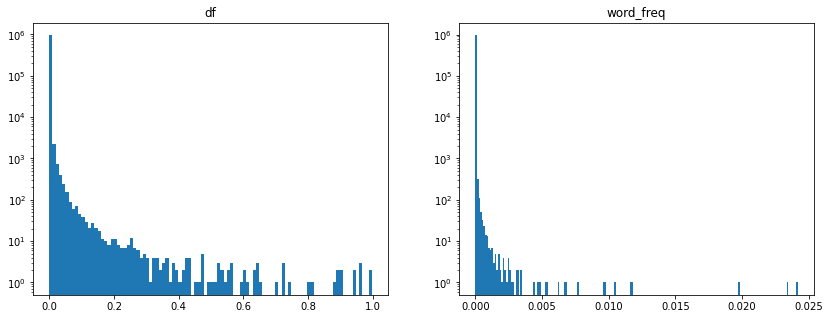

In [24]:
def show_freq(dataset, labels, bigrams=True):
    word_to_ind = {}
    free_ind = 0

    pos_words = defaultdict(int)
    word_in_pos_text = defaultdict(int)
    neg_words = defaultdict(int)
    word_in_neg_text = defaultdict(int)
    cnt_pos = 0
    cnt_neg = 0
    N_words = -1
    prob_w_cls = []
    prob_cls = []
    bigrams = True
    trigrams = True
    #--------------------------------------
    train_pos = [dataset[i] for i, lab in enumerate(labels) if lab == 'pos']
    train_pos = list(map(preprocessing, train_pos))
    train_pos = tokenize_dataset(train_pos)

    train_neg = [dataset[i] for i, lab in enumerate(labels) if lab == 'neg']
    train_neg = list(map(preprocessing, train_neg))
    train_neg = tokenize_dataset(train_neg)

    for text in train_pos:
        been = set()
        for word in text:
            if word not in word_to_ind:
                word_to_ind[word] = free_ind
                free_ind += 1
            if word not in been:
                ind = word_to_ind[word]
                word_in_pos_text[ind] += 1
                been.add(word)
            pos_words[word_to_ind[word]] += 1
            cnt_pos += 1

    if bigrams:
        for text in train_pos:
            been = set()
            bigr = [b for b in zip(text[:-1], text[1:])]
            for word in bigr:
                if word not in word_to_ind:
                    word_to_ind[word] = free_ind
                    free_ind += 1
                if word not in been:
                    ind = word_to_ind[word]
                    word_in_pos_text[ind] += 1
                    been.add(word)
                pos_words[word_to_ind[word]] += 1
                cnt_pos += 1


    for text in train_neg:
        been = set()
        for word in text:
            if word not in word_to_ind:
                word_to_ind[word] = free_ind
                free_ind += 1
            if word not in been:
                ind = word_to_ind[word]
                word_in_neg_text[ind] += 1
                been.add(word)    
            neg_words[word_to_ind[word]] += 1
            cnt_neg += 1

    if bigrams:
        for text in train_neg:
            been = set()
            bigr = [b for b in zip(text[:-1], text[1:])]
            for word in bigr:
                if word not in word_to_ind:
                    word_to_ind[word] = free_ind
                    free_ind += 1
                if word not in been:
                    ind = word_to_ind[word]
                    word_in_neg_text[ind] += 1
                    been.add(word)
                neg_words[word_to_ind[word]] += 1
                cnt_neg += 1
                    
    all_tokens = cnt_pos + cnt_neg
    all_docs = len(train_pos) + len(train_neg)
    ind_df = {}
    ind_w_freq = {}
    print(len(word_to_ind))
    for w, ind in word_to_ind.items():
#         cnt_freq[ind] = ((pos_words[w] + neg_words[w]) / all_tokens)
        ind_df[ind] = (word_in_pos_text[ind] + word_in_neg_text[ind]) / all_docs
        ind_w_freq[ind] = (pos_words[ind] + neg_words[ind]) / all_tokens
    

    df = sorted(list(ind_df.values()))
    word_freq = sorted(list(ind_w_freq.values()))
    
    fig = plt.figure(figsize = (14, 5))
    ax1 = plt.subplot(121)
    f = ax1.hist(df, bins=100)
    ax1.set_yscale('log')
    ax1.set_title("df")
    
    ax2 = plt.subplot(122)
    f = ax2.hist(word_freq, bins=200)
    ax2.set_title("word_freq")
    ax2.set_yscale('log')
    
train_texts_path = "./filimdb_evaluation/FILIMDB/train.texts"
train_labels_path = "./filimdb_evaluation/FILIMDB/train.labels"
with open(train_texts_path, 'r', encoding='utf-8') as inp:
    train_data = list(map(str.strip, inp.readlines()))
with open(train_labels_path, 'r', encoding='utf-8') as inp:
    train_labels = list(map(str.strip, inp.readlines()))
show_freq(train_data, train_labels)

Из гистограммы видно, что есть всего около 1000 слов которые встерчаются более чем в 10 процентах текстов выборки.\
Если их выкинуть, то будет прирост по точности.
Также я решил посмотреть на частотность слов, которые встречаются в выборке.\
После подбора этого параметра выяснилось, что если ограничить частотность слов до 0.00005, то можно ещё немного повысить точность(на 0.1).

In [25]:
def train(dataset, labels, tf_min_cnt=3, freq_treshhold=0.00005, max_df=0.1, bigrams=True):
    word_to_ind = {}
    free_ind = 0

    pos_words = defaultdict(int)
    word_in_pos_text = defaultdict(int)
    neg_words = defaultdict(int)
    word_in_neg_text = defaultdict(int)
    cnt_pos = 0
    cnt_neg = 0
    N_words = -1
    prob_w_cls = []
    prob_cls = []
#     bigrams = True
    #--------------------------------------
    train_pos = [dataset[i] for i, lab in enumerate(labels) if lab == 'pos']
    train_pos = list(map(preprocessing, train_pos))
    train_pos = tokenize_dataset(train_pos)

    train_neg = [dataset[i] for i, lab in enumerate(labels) if lab == 'neg']
    train_neg = list(map(preprocessing, train_neg))
    train_neg = tokenize_dataset(train_neg)

    for text in train_pos:
        been = set()
        for word in text:
            pos_words[word] += 1
            cnt_pos += 1
            if word not in word_to_ind:
                word_to_ind[word] = free_ind
                free_ind += 1
            if word not in been:
                ind = word_to_ind[word]
                word_in_pos_text[ind] += 1
                been.add(word)

    if bigrams:
        for text in train_pos:
            been = set()
            bigrams = [b for b in zip(text[:-1], text[1:])]
            for word in bigrams:
                pos_words[word] += 1
                cnt_pos += 1
                if word not in word_to_ind:
                    word_to_ind[word] = free_ind
                    free_ind += 1
                if word not in been:
                    ind = word_to_ind[word]
                    word_in_pos_text[ind] += 1
                    been.add(word)

    for text in train_neg:
        been = set()
        for word in text:
            neg_words[word] += 1
            cnt_neg += 1
            if word not in word_to_ind:
                word_to_ind[word] = free_ind
                free_ind += 1
            if word not in been:
                ind = word_to_ind[word]
                word_in_neg_text[ind] += 1
                been.add(word)    

    if bigrams:
        for text in train_neg:
            been = set()
            bigrams = [b for b in zip(text[:-1], text[1:])]
            for word in bigrams:
                neg_words[word] += 1
                cnt_neg += 1
                if word not in word_to_ind:
                    word_to_ind[word] = free_ind
                    free_ind += 1
                if word not in been:
                    ind = word_to_ind[word]
                    word_in_neg_text[ind] += 1
                    been.add(word)
                    
    all_tokens = cnt_pos + cnt_neg
    # Deleting words with freq > freq_treshhold.
    for w, ind in list(word_to_ind.items()):
        w_pos = pos_words[w]
        w_neg = neg_words[w]
        w_pos_text = word_in_pos_text[ind]
        w_neg_text = word_in_neg_text[ind]
        if ((w_pos + w_neg) / all_tokens > freq_treshhold) or ((w_pos_text + w_neg_text) / len(dataset) > max_df) \
            or (w_pos + w_neg < tf_min_cnt):
#             print("delete : ", w)
            cnt_pos -= pos_words[w]
            cnt_neg -= neg_words[w]
            pos_words.pop(w, -1)
            neg_words.pop(w, -1)
            word_in_pos_text.pop(ind, -1)
            word_in_neg_text.pop(ind, -1)
            word_to_ind.pop(w, -1)
    
    new_word_to_ind = {}
    new_word_in_neg_text = {}
    new_word_in_pos_text = {}
    for ind, (w, old_ind) in enumerate(word_to_ind.items()):
        try:
            new_word_to_ind[w] = ind
            new_word_in_neg_text[ind] = word_in_neg_text[old_ind]
            new_word_in_pos_text[ind] = word_in_pos_text[old_ind]
        except Exception:
            print(ind, w, old_ind)
    
    word_to_ind = new_word_to_ind
    word_in_pos_text = new_word_in_pos_text
    word_in_neg_text = new_word_in_neg_text
    
    N_words = len(word_to_ind)

    def cnt_prob_word_cls(ind, cls):
        if cls == 'neg':
            cnt = word_in_neg_text[ind] if ind != -1 else 0
            return (1 + cnt) / (cnt_neg + len(word_to_ind))
        else:
            cnt = word_in_pos_text[ind] if ind != -1 else 0
            return (1 + cnt) / (cnt_pos + len(word_to_ind))

    def cnt_prob_cls(cls):
    # 0 - neg, 1 - pos
        if cls == 0:
            return len(train_neg) / (len(train_neg) + len(train_pos))
        else:
            return len(train_pos) / (len(train_neg) + len(train_pos))

    prob_w_cls = [[cnt_prob_word_cls(i, cls) for i in range(N_words)] + [cnt_prob_word_cls(-1, cls)] for cls in ('neg', 'pos')]
    prob_cls = [cnt_prob_cls(cls) for cls in ('neg', 'pos')]

    return word_to_ind, prob_w_cls, prob_cls, bigrams

In [26]:

test_model({'freq_treshhold':0.00005,'tf_min_cnt':1,'max_df':0.2, 'bigrams':True})[0]

TRAINING DONE
CLASSIFY DONE


,train_acc,dev_acc
1,0.997667,0.8836


### с) Что будет, если поменять предобработку?


**1.** Поменять числа на токен NUMBER.

In [31]:
def preprocessing(text):
    text = text.lower()
    remove_tags = re.compile(r'<.*?>')
    text = re.sub(remove_tags, '', text)
    remove_numbers = re.compile(r'-?\d*[.,]?\d+')
    text = re.sub(remove_numbers, 'NUMBER', text)
    text = ''.join(sym if (sym.isalnum() or sym in (" ", "'")) else f" {sym} " for sym in text)
    return text

In [32]:

test_model({'freq_treshhold':1,'tf_min_cnt':1,'max_df':1, 'bigrams':True})[0]

TRAINING DONE
CLASSIFY DONE


,train_acc,dev_acc
1,0.991533,0.8713


In [33]:

test_model({'freq_treshhold':0.00005,'tf_min_cnt':1,'max_df':0.2, 'bigrams':True})[0]

TRAINING DONE
CLASSIFY DONE


,train_acc,dev_acc
1,0.9974,0.8812


Получаем ухудшение по точности. Вроде бы очевидно, что цифры дают какую-то информацию(например, оценки) и убирать её смысла особого нет.

**2.** Убрать все знаки препинания.

In [34]:
def preprocessing(text):
    text = text.lower()
    remove_tags = re.compile(r'<.*?>')
    text = re.sub(remove_tags, '', text)
    text = re.sub(r'[^\w\s]', '', text) 
    text = ''.join(sym if (sym.isalnum() or sym in (" ", "'")) else f" {sym} " for sym in text)
    return text

In [35]:

test_model({'freq_treshhold':1,'tf_min_cnt':1,'max_df':1, 'bigrams':True})[0]

TRAINING DONE
CLASSIFY DONE


,train_acc,dev_acc
1,0.996533,0.8737


In [36]:

test_model({'freq_treshhold':0.00005,'tf_min_cnt':1,'max_df':0.2, 'bigrams':True})[0]

TRAINING DONE
CLASSIFY DONE


,train_acc,dev_acc
1,0.999067,0.8803


Не понятно почему, но со знаками препинания точность больше при любых условиях.\
Но трейн предсказывает лучше)

**3.** Попробуем применить стемминг.\
    Хорошо работает обрезание всех слов до 7 символов.

In [39]:
def preprocessing(text):
    text = text.lower()
    remove_tags = re.compile(r'<.*?>')
    text = re.sub(remove_tags, '', text)
    text = ''.join(sym if (sym.isalnum() or sym in (" ", "'")) else f" {sym} " for sym in text)
    return text


def tokenize_dataset(dataset):
    tokenizer = re.compile(r"-?\d*[.,]?\d+|([?'\w]+)|(\S)", re.MULTILINE | re.IGNORECASE)
    tokenized_dataset = list(map(lambda doc: tokenizer.findall(doc), dataset))
    stem_dataset = [[token[:7] for token in text] for text in tokenized_dataset]
    return stem_dataset

In [40]:

test_model({'freq_treshhold':1,'tf_min_cnt':1,'max_df':1, 'bigrams':True})[0]

TRAINING DONE
CLASSIFY DONE


,train_acc,dev_acc
1,0.992533,0.8743


In [41]:

test_model({'freq_treshhold':0.00005,'tf_min_cnt':1,'max_df':0.2, 'bigrams':True})[0]

TRAINING DONE
CLASSIFY DONE


,train_acc,dev_acc
1,0.9978,0.8817


Тут видно, что при текущих условиях не особо помогает, но в финальной модели работает лучше.

### с) Посмотрим как зависят друг от друга длина текста и его класс

Text(0.5, 1.0, 'Negative texts')

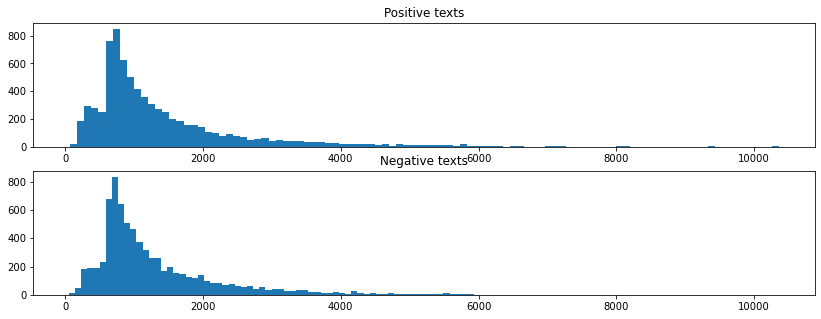

In [43]:
train_texts_path = "./filimdb_evaluation/FILIMDB/train.texts"
train_labels_path = "./filimdb_evaluation/FILIMDB/train.labels"
with open(train_texts_path, 'r', encoding='utf-8') as inp:
    train_data = list(map(str.strip, inp.readlines()))
with open(train_labels_path, 'r', encoding='utf-8') as inp:
    train_labels = list(map(str.strip, inp.readlines()))
    
pos_len = [len(train_data[i]) for i, lab in enumerate(train_labels) if lab == 'pos']
neg_len = [len(train_data[i]) for i, lab in enumerate(train_labels) if lab == 'neg']

fig = plt.figure(figsize = (14, 5))
ax1 = plt.subplot(211)
f = ax1.hist(pos_len, bins=100)
ax1.set_title("Positive texts")
ax2 = plt.subplot(212, sharex=ax1)
f = ax2.hist(neg_len, bins=100)
ax2.set_title("Negative texts")

Можно увидеть, что длины текстов распредлены почти одинаково для двух классов, значит длина текста не будет влиять на определение его класса.

### d) Что будет, если незнакомые слова из тестовой выборки помечать специальным токеном?

Будет большое понижение по точности, потому что это могут быть опечатки и другие слова не несущие значения для классификации.\
И при этом, все они будут идти под одним токеном, т.е будут вносить существенный вклад для мультиномиальной модели.\
Тут проверки не будет, но локально я проверял.

### e) Работа с неразмеченными текстами?

Я пытался реализовать ЕМ-алгоритм, при котором мы тренируем классификатор на train выборке.\
Потом этим классификатором размечаем unlabeled_test выборку и затем тренируемся на размеченной выборке из train и unlabeled_test.\
Все эти разметки и тренировки должны повторяться, пока значения вероятностей не сойдутся.

Но на практике...
1. При обучении на размеченных train и unlabeled_test точность снижалась значительно (до 78-79 процентов).
2. Если повторять шаги разметки и тренировки, то точность опять же снижалась.

С чем это связано я так и не смог понять, при этом на совсем маленьких данных (5-6 коротких текстов) алгоритм работал. Возможно дело в недостаточной предобработке(но она была неплохой) или сильно большей длине текстов в train и dev выборках.

### f) Что-нибудь ещё?


Тут появляются триграммы, они позволили немного добавить точности.

In [65]:
def train(dataset, labels, max_df=0.1, min_df=1, freq_treshhold=1):
    word_to_ind = {}
    free_ind = 0

    pos_words = defaultdict(int)
    word_in_pos_text = defaultdict(int)
    neg_words = defaultdict(int)
    word_in_neg_text = defaultdict(int)
    df = defaultdict(int)
    df_cnt = defaultdict(int)
    w_freq = defaultdict(int)
    cnt_pos = 0
    cnt_neg = 0
    N_words = -1
    prob_w_cls = []
    prob_cls = []
    bigrams = True
    trigrams = True

    proc_dataset = list(map(preprocessing, dataset))
    token_dataset = tokenize_dataset(proc_dataset)
    # print(token_dataset[0])
    
    min_group = min(labels.count('pos'), labels.count('neg'))
    train_pos = [token_dataset[i] for i, lab in enumerate(labels) if lab == 'pos']
    # train_pos = train_pos[:min_group]

    train_neg = [token_dataset[i] for i, lab in enumerate(labels) if lab == 'neg']
    # train_neg = train_neg[:min_group]

    # print(f"train_pos_size: {len(train_pos)}, train_neg_size: {len(train_neg)}")
    # print("all_tokens: ", sum(len(text) for text in token_dataset) + sum(len(list(zip(text[:-1], text[1:]))) for text in token_dataset))
    # print()

    for text in train_pos:
        been = set()
        for word in text:
            if word not in word_to_ind:
                word_to_ind[word] = free_ind
                free_ind += 1
            if word not in been:
                ind = word_to_ind[word]
                word_in_pos_text[ind] += 1
                been.add(word)
            pos_words[word_to_ind[word]] += 1
            cnt_pos += 1

    if bigrams:
        for text in train_pos:
            been = set()
            bigr = [b for b in zip(text[:-1], text[1:])]
            for word in bigr:
                if word not in word_to_ind:
                    word_to_ind[word] = free_ind
                    free_ind += 1
                if word not in been:
                    ind = word_to_ind[word]
                    word_in_pos_text[ind] += 1
                    been.add(word)
                pos_words[word_to_ind[word]] += 1
                cnt_pos += 1

    if trigrams:
        for text in train_pos:
            been = set()
            trigr = [b for b in zip(text[:-2], text[1:-1], text[2:])]
            for word in trigr:
                if word not in word_to_ind:
                    word_to_ind[word] = free_ind
                    free_ind += 1
                if word not in been:
                    ind = word_to_ind[word]
                    word_in_pos_text[ind] += 1
                    been.add(word)
                pos_words[word_to_ind[word]] += 1
                cnt_pos += 1

    for text in train_neg:
        been = set()
        for word in text:
            if word not in word_to_ind:
                word_to_ind[word] = free_ind
                free_ind += 1
            if word not in been:
                ind = word_to_ind[word]
                word_in_neg_text[ind] += 1
                been.add(word)    
            neg_words[word_to_ind[word]] += 1
            cnt_neg += 1

    if bigrams:
        for text in train_neg:
            been = set()
            bigr = [b for b in zip(text[:-1], text[1:])]
            for word in bigr:
                if word not in word_to_ind:
                    word_to_ind[word] = free_ind
                    free_ind += 1
                if word not in been:
                    ind = word_to_ind[word]
                    word_in_neg_text[ind] += 1
                    been.add(word)
                neg_words[word_to_ind[word]] += 1
                cnt_neg += 1

    if trigrams:
        for text in train_neg:
            been = set()
            trigr = [b for b in zip(text[:-2], text[1:-1], text[2:])]
            for word in trigr:
                if word not in word_to_ind:
                    word_to_ind[word] = free_ind
                    free_ind += 1
                if word not in been:
                    ind = word_to_ind[word]
                    word_in_neg_text[ind] += 1
                    been.add(word)
                neg_words[word_to_ind[word]] += 1
                cnt_neg += 1

    def cnt_prob_word_cls(ind, cls, alpha=1):
        if cls == 'neg':
            cnt = neg_words[ind] if ind != -1 else 0
            return (alpha + cnt) / (cnt_neg + alpha*len(word_to_ind))
        else:
            cnt = pos_words[ind] if ind != -1 else 0
            return (alpha + cnt) / (cnt_pos + alpha*len(word_to_ind))

    def cnt_prob_cls(cls):
    # 0 - neg, 1 - pos
        if cls == 0:
            return len(train_neg) / (len(train_neg) + len(train_pos))
        else:
            return len(train_pos) / (len(train_neg) + len(train_pos))


    # Train with unlabeled data
    #--------------------------------------

    #--------------------------------------

    for w, ind in word_to_ind.items():
        df[ind] = (word_in_neg_text[ind] + word_in_pos_text[ind]) / len(dataset)
        df_cnt[ind] = (word_in_neg_text[ind] + word_in_pos_text[ind])
    
    for w, ind in word_to_ind.items():
        w_freq[ind] = (pos_words[ind] + neg_words[ind]) / (cnt_pos + cnt_neg)

    # Deleting words with freq > freq_treshhold.
    for w, ind in list(word_to_ind.items()):
        if df[ind] > max_df or w_freq[ind] > freq_treshhold or df_cnt[ind] < min_df:
            # print("delete : ", w, ind)
            # print("Probs: ", cnt_prob_word_cls(ind, 'neg'), cnt_prob_word_cls(ind, 'pos'))
            cnt_pos -= pos_words[ind]
            cnt_neg -= neg_words[ind]
            pos_words.pop(w, -1)
            neg_words.pop(w, -1)
            word_in_pos_text.pop(ind, -1)
            word_in_neg_text.pop(ind, -1)
            word_to_ind.pop(w, -1)
    
    new_word_to_ind = {}
    new_word_in_neg_text = {}
    new_word_in_pos_text = {}
    new_pos_words = {}
    new_neg_words = {}
    new_df_cnt = {}
    new_w_freq = {}
    for ind, (w, old_ind) in enumerate(word_to_ind.items()):
        try:
            new_word_to_ind[w] = ind
            new_word_in_neg_text[ind] = word_in_neg_text[old_ind]
            new_word_in_pos_text[ind] = word_in_pos_text[old_ind]
            new_pos_words[ind] = pos_words[old_ind]
            new_neg_words[ind] = neg_words[old_ind]
            new_df_cnt[ind] = df_cnt[old_ind]
            new_w_freq[ind] = df[old_ind]
        except Exception:
            print(ind, w, old_ind)
    
    word_to_ind = new_word_to_ind
    word_in_pos_text = new_word_in_pos_text
    word_in_neg_text = new_word_in_neg_text
    pos_words = new_pos_words
    neg_words = new_neg_words
    df_cnt = new_df_cnt
    w_freq = new_w_freq

    N_words = len(word_to_ind)
    print(N_words)
    prob_w_cls = [[cnt_prob_word_cls(i, cls) for i in range(N_words)] for cls in ('neg', 'pos')]
    prob_cls = [cnt_prob_cls(cls) for cls in ('neg', 'pos')]

    # print(prob_w_cls)   
    return word_to_ind, df_cnt, prob_w_cls, prob_cls, bigrams, trigrams

In [66]:
def vectorize(tokenized_texts, word_to_ind, df_cnt, mode, bigrams=True, trigrams=True):
    res = [defaultdict(int) for _ in range(len(tokenized_texts))]
    for ind, text in enumerate(tokenized_texts):
        for token in text:
            if token in word_to_ind:
                res[ind][word_to_ind[token]] += 1
    if bigrams:
        for ind, text in enumerate(tokenized_texts):
            bigr = [b for b in zip(text[:-1], text[1:])]
            for token in bigr:
                if token in word_to_ind:
                    res[ind][word_to_ind[token]] += 1
    if trigrams:
        for ind, text in enumerate(tokenized_texts):
            trigr = [b for b in zip(text[:-2], text[1:-1], text[2:])]
            for token in trigr:
                if token in word_to_ind:
                    res[ind][word_to_ind[token]] += 1
    if mode == 'bern':
        for text in res:
            for ind, cnt in text.items():
                if cnt > 0:
                    text[ind] = 1
    if mode == 'tfidf':
        for text in res:
            for ind, cnt in text.items():
                text[ind] /= len(text)
                idf = log((1 + len(tokenized_texts))/(1 + df_cnt[ind])  + 1)
                text[ind] *= idf
    return res

In [73]:
def classify(dataset, params):
    #preprocessing
    word_to_ind, df_cnt, prob_w_cls, prob_cls, bigr, trigr = params
    dataset = list(map(preprocessing, dataset))
    dataset = tokenize_dataset(dataset)
    dataset = vectorize(dataset, word_to_ind, df_cnt, mode='mult', bigrams=bigr, trigrams=trigr)
    probs = []
    size = len(dataset)
    for i, text in enumerate(dataset):
        probs.append(classify_mult(text, prob_w_cls, prob_cls))
    res = ['pos' if pr else 'neg' for pr in probs]
    return res

In [74]:
test_model({'freq_treshhold':1,'max_df':1})[0]

3399431
TRAINING DONE
CLASSIFY DONE


,train_acc,dev_acc
1,0.999267,0.8859


И тут появляется он, **улучшенный токенизатор**.

In [76]:
def tokenize_dataset(dataset):
    """
        arg: list of texts
        return: list of tokenized texts
    """
    stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', \
    'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with',
     'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
    tokenizer = re.compile(r"-?\d*[.,]?\d+|([?'\w]+)|(\S)", re.MULTILINE | re.IGNORECASE)
    tokenized_dataset = list(map(lambda doc: tokenizer.findall(doc), dataset))
    stem_dataset = [[token[:7] for token in text if token not in stop_words] for text in tokenized_dataset]
    return stem_dataset

Тут добавлено удаление некоторых стоп-слов английского языка (они не несут никакой значимости для классификации).\
Но это не главное.\
А главное тут то, что ошибка в регулярном выражении превратила все токены вида ('token',) в токены вида ('token', ' ').\
и как ни странно это позволило мультиномиальной преодолеть 89 процентов точности.

In [82]:
test_model({'freq_treshhold':1,'min_df':1,'max_df':1})[0]

3399431
TRAINING DONE
CLASSIFY DONE


,train_acc,dev_acc
1,0.999267,0.8859


In [83]:
test_model({'freq_treshhold':1,'min_df':1,'max_df':0.1})[0]

3399087
TRAINING DONE
CLASSIFY DONE


,train_acc,dev_acc
1,0.9996,0.8919


И в финальной версии оказалось, что tf-idf векторизация даёт ещё немного точности, хотя до этого она не помогала.

In [86]:
def classify(dataset, params):
    #preprocessing
    word_to_ind, df_cnt, prob_w_cls, prob_cls, bigr, trigr = params
    dataset = list(map(preprocessing, dataset))
    dataset = tokenize_dataset(dataset)
    dataset = vectorize(dataset, word_to_ind, df_cnt, mode='tfidf', bigrams=bigr, trigrams=trigr)
    probs = []
    size = len(dataset)
    for i, text in enumerate(dataset):
        probs.append(classify_mult(text, prob_w_cls, prob_cls))
    res = ['pos' if pr else 'neg' for pr in probs]
    return res

In [87]:
test_model({'freq_treshhold':1,'min_df':1,'max_df':0.1})[0]

3399087
TRAINING DONE
CLASSIFY DONE


,train_acc,dev_acc
1,1.0,0.8945


На этой точности я решил остановиться, т.к всё, что смог придумать или прочитать, уже попробовал.